In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from kats.consts import TimeSeriesData
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters
from kats.models.prophet import ProphetModel, ProphetParams
from causalimpact import CausalImpact
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


plt.rcParams["figure.figsize"] = (14,5)
sns.set_style('darkgrid')

In [3]:
data = pd.read_csv('data/Retail Sales.csv')
data.head()

,DATE,Sales
0,1/1/1992,1509
1,2/1/1992,1541
2,3/1/1992,1597
3,4/1/1992,1675
4,5/1/1992,1822


In [4]:
def transform_and_split_data(data, transform=False, split=False, **split_keys):
    if transform == True: 
        # print('yes')
        time_series = pd.Series(data['Sales'].values, index=pd.date_range(start_data, periods= row_shape, freq=date_frequency))
    else:
        time_series = data
    if split == True:
        new_data_train = time_series.ix[split_keys['train_set_row_start']:split_keys['train_set_row_end'],split_keys['train_set_column_start']:split_keys['train_set_column_end']]
        new_data_test = time_series.ix[split_keys['test_set_row_start']:split_keys['test_set_row_end'],split_keys['test_set_column_start']:split_keys['test_set_column_end']]
    else:
        new_data_train = None
        new_data_test = None
    results = {'data': time_series, 'training_data':new_data_train, 'test_data':new_data_test}
    return results





In [5]:
def transform_and_split_data(data, transform=False, split=False, **split_keys):
    if transform == True and split==True: 
        time_series = pd.Series(data['Sales'].values, index=pd.date_range(start_data, periods= row_shape, freq=date_frequency))
        new_data_train = time_series.iloc[split_keys['train_set_row_start']:split_keys['train_set_row_end']]
        new_data_test = time_series.iloc[split_keys['test_set_row_start']:split_keys['test_set_row_end']]
    elif transform == False and split==True:
        time_series = data
        new_data_train = time_series.iloc[split_keys['train_set_row_start']:split_keys['train_set_row_end'],split_keys['train_set_column_start']:split_keys['train_set_column_end']]
        new_data_test = time_series.iloc[split_keys['test_set_row_start']:split_keys['test_set_row_end'],split_keys['test_set_column_start']:split_keys['test_set_column_end']]
    else:
        time_series = pd.Series(data['Sales'].values, index=pd.date_range(start_data, periods= row_shape, freq=date_frequency))
        new_data_train = None
        new_data_test = None
    results = {'data': time_series, 'training_data':new_data_train, 'test_data':new_data_test}
    return results

In [6]:
start_data = '1992-01-01'
row_shape = data.shape[0]
date_frequency = 'M'

results = transform_and_split_data(data, True, False)

<AxesSubplot:>

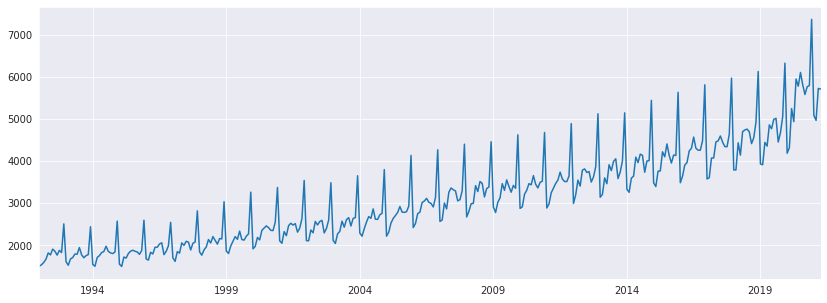

In [7]:
time_series = results['data']
time_series.plot()

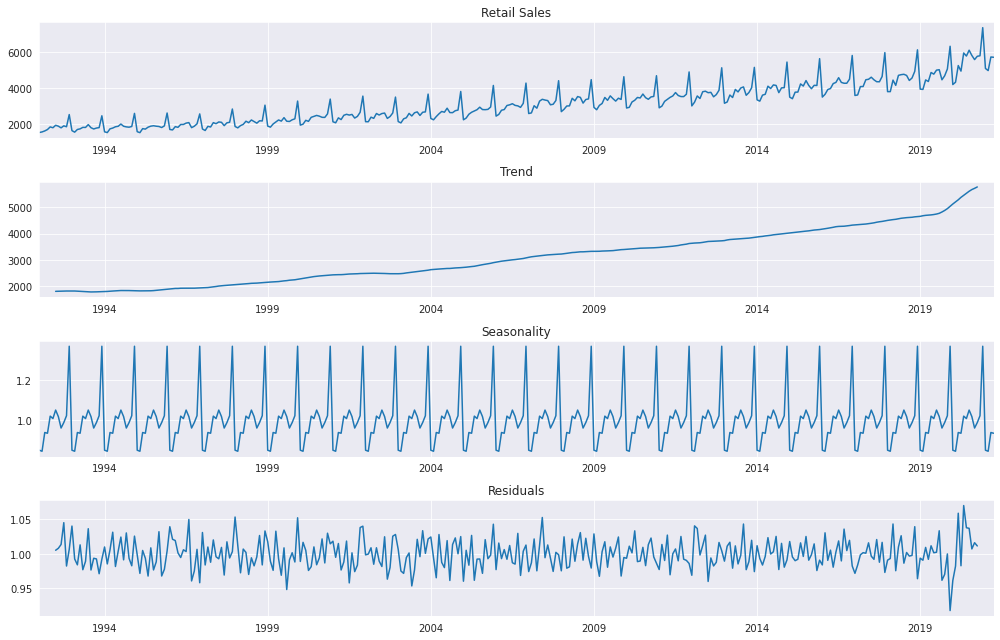

In [8]:
# fig = plt.figure(figsize=(14,9))
patterns_decomposed = seasonal_decompose(time_series, model='multiplicative')
fig , (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(14,9))
patterns_decomposed.observed.plot(ax=ax1)
patterns_decomposed.trend.plot(ax=ax2)
patterns_decomposed.seasonal.plot(ax=ax3)
patterns_decomposed.resid.plot(ax=ax4)
ax1.set_title('Retail Sales')
ax2.set_title('Trend')
ax3.set_title('Seasonality')
ax4.set_title('Residuals')
plt.tight_layout()
# patterns_decomposed.

In [9]:

new_data = data.iloc[:,:]
new_data = new_data.rename(columns={'DATE':'time','Sales':'value'})
ts = TimeSeriesData(new_data)


TimeSeriesChangePoint(start_time: 2020-05-01T00:00:00.000000000, end_time: 2020-05-01T00:00:00.000000000, confidence: 0.7075252873104964)


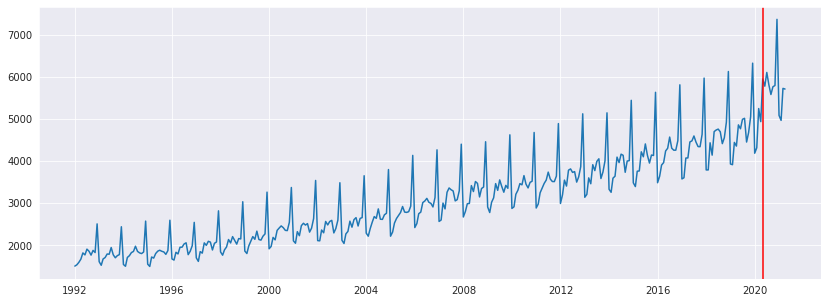

None


In [10]:
bocpd_detector = BOCPDetector(ts)

changepoints = bocpd_detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL, changepoint_prior=0.1
)
for changepoint in changepoints:
    print(changepoint[0])
    
# Plot
print(bocpd_detector.plot(changepoints))


In [11]:
split_keys = {
    'train_set_row_start': 0
    , 'train_set_row_end': -8
    , 'train_set_column_start': None
    , 'train_set_column_end': None
    , 'test_set_row_start': -8
    , 'test_set_row_end': None
    , 'test_set_column_start': None
    , 'test_set_column_end': None
}

In [12]:
splitted_data = transform_and_split_data(data,True,True, **split_keys)

In [13]:
training_data = splitted_data['training_data']


In [14]:
# Define training data - period prior to the event
pre_period = ['1992-01-31', '2020-04-30'] 
# Define post-event period - i.e. time AFTER the event occurred.
post_period = ['2020-05-31', '2020-08-31'] 
# Instantiate CI model.
ci = CausalImpact(training_data, pre_period, post_period, nseasons=[{'period': 12}])

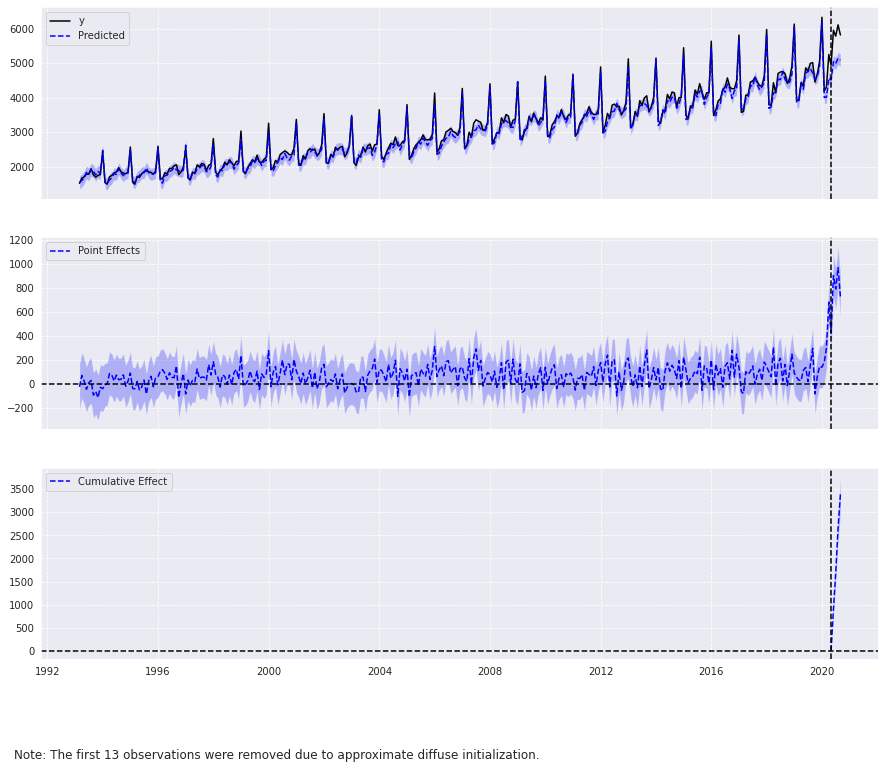

In [15]:
ci.plot()

In [16]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    5912.25            23649.0
Prediction (s.d.)         5064.98 (50.81)    20259.94 (203.25)
95% CI                    [4966.62, 5165.8]  [19866.49, 20663.2]

Absolute effect (s.d.)    847.27 (50.81)     3389.06 (203.25)
95% CI                    [746.45, 945.63]   [2985.8, 3782.51]

Relative effect (s.d.)    16.73% (1.0%)      16.73% (1.0%)
95% CI                    [14.74%, 18.67%]   [14.74%, 18.67%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [17]:
print(ci.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 5912.25. By contrast, in the absence of an
intervention, we would have expected an average response of 5064.98.
The 95% interval of this counterfactual prediction is [4966.62, 5165.8].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 847.27 with a 95% interval of
[746.45, 945.63]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 23649.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 20259.94. The 95% interval of this prediction is [19866.49, 20663.2].


The above results are given in terms of absolute numbers. In relative
terms, the

In [18]:
ci.trained_model.summary()

/root/venv/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



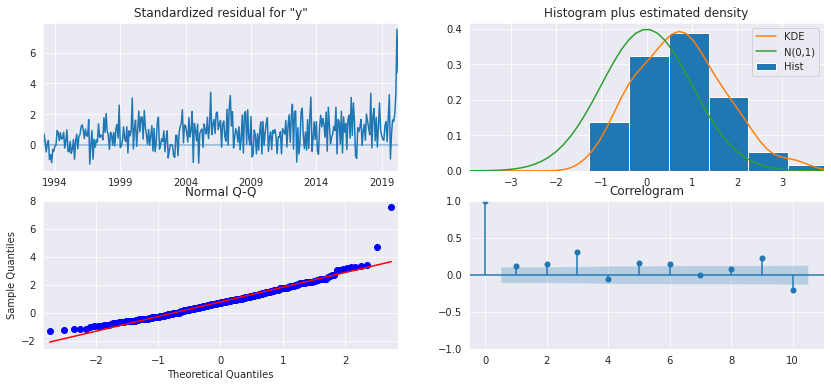

In [19]:
_ = ci.trained_model.plot_diagnostics(figsize=(14,6))

In [20]:

training_forecast_data = training_data.reset_index()
training_forecast_data = training_forecast_data.rename(columns={'index':'time','0':'value'})
kat_series = TimeSeriesData(training_forecast_data)
# training_forecast_data

In [21]:
params = ProphetParams(seasonality_mode="multiplicative")

# Create a model instance
m = ProphetModel(kat_series, params)

# Fit mode
m.fit()

# Forecast
forecast = m.predict(steps=8, freq=date_frequency)
# print(forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Initial log joint probability = -4.71999
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1176.3    0.00188434       166.243      0.1573      0.1573      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       1181.55   0.000101941        168.43   7.197e-07       0.001      250  LS failed, Hessian reset 
     199        1183.2     0.0039196       220.267           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       1183.34   0.000871969       368.834   6.463e-06       0.001      330  LS failed, Hessian reset 
     262       1184.22   6.67804e-05       115.102   5.223e-07       0.001      4

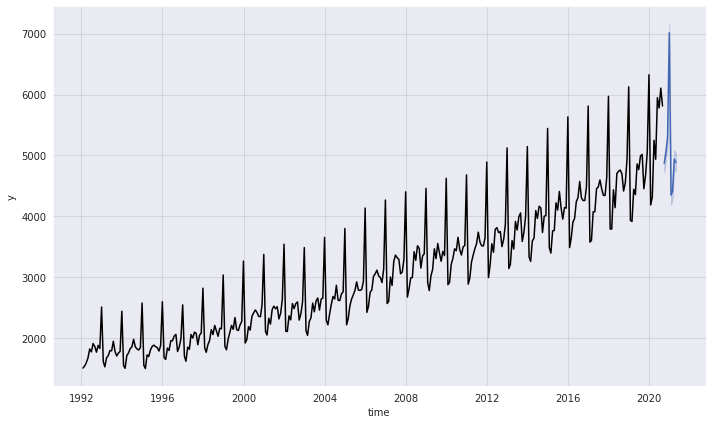

In [22]:
m.plot()

In [23]:
forecast_dataframe = pd.DataFrame(forecast).round(0)
test_data = splitted_data['test_data']
forecast_dataframe['actual_sales'] = list(test_data.values)
forecast_dataframe['if_meet_boundaries'] =  forecast_dataframe['actual_sales'].between(forecast_dataframe['fcst_lower'], forecast_dataframe['fcst_upper'])
forecast_dataframe

,time,fcst,fcst_lower,fcst_upper,actual_sales,if_meet_boundaries
0,2020-09-30,4869.0,4720.0,5016.0,5582,False
1,2020-10-31,5038.0,4906.0,5180.0,5766,False
2,2020-11-30,5289.0,5156.0,5434.0,5796,False
3,2020-12-31,7016.0,6868.0,7165.0,7366,False
4,2021-01-31,4348.0,4190.0,4490.0,5087,False
5,2021-02-28,4413.0,4270.0,4552.0,4968,False
6,2021-03-31,4941.0,4788.0,5089.0,5727,False
7,2021-04-30,4884.0,4744.0,5039.0,5712,False


In [24]:

relative_effect_sales = (ci.summary_data.loc[['rel_effect_lower','rel_effect','rel_effect_upper'],['average']].values).T + 1
effect_names = ['rel_effect_lower','rel_effect','rel_effect_upper']

In [25]:
dataframe_columns=['fcst', 'fcst_lower', 'fcst_upper']
def get_adjusted_forecasts(forecast_dataframe,dataframe_columns, relative_effect_sales):
    dic_store = {}
    # count = 0
    for column in dataframe_columns:
        forecast_value = forecast_dataframe[column].values.reshape(-1,1)
        adjusted_results = forecast_value * relative_effect_sales
        dic_store[column] = adjusted_results.T
        # count += 1
    return dic_store


def add_adjusted_forecast_to_dataframe(forecast_dataframe,dataframe_columns, relative_effect_sales):
    results = get_adjusted_forecasts(forecast_dataframe,dataframe_columns, relative_effect_sales)
    print('done')
    count = 0
    count
    for k,v in results.items():
        forecast_dataframe[k+'_'+effect_names[0]],forecast_dataframe[k+'_'+effect_names[1]], forecast_dataframe[k+'_'+effect_names[2]]  = v[0],v[1],v[2]
        count +=1
    forecast_dataframe = forecast_dataframe.round(0)
    print('done')



In [26]:
add_adjusted_forecast_to_dataframe(forecast_dataframe,dataframe_columns, relative_effect_sales)

done
done


In [27]:
forecast_dataframe.columns

Index(['time', 'fcst', 'fcst_lower', 'fcst_upper', 'actual_sales',
       'if_meet_boundaries', 'fcst_rel_effect_lower', 'fcst_rel_effect',
       'fcst_rel_effect_upper', 'fcst_lower_rel_effect_lower',
       'fcst_lower_rel_effect', 'fcst_lower_rel_effect_upper',
       'fcst_upper_rel_effect_lower', 'fcst_upper_rel_effect',
       'fcst_upper_rel_effect_upper'],
      dtype='object')

In [28]:
forecast_dataframe['if_adjustments_forecast_meets_boundaries'] = forecast_dataframe['actual_sales'].between(forecast_dataframe['fcst_rel_effect_lower'], forecast_dataframe['fcst_rel_effect_upper'])
forecast_dataframe['if_adjustments_forecast_lower_meets_boundaries'] = forecast_dataframe['actual_sales'].between(forecast_dataframe['fcst_lower_rel_effect_lower'], forecast_dataframe['fcst_lower_rel_effect_upper'])
forecast_dataframe['if_adjustments_forecast_upper_meets_boundaries'] = forecast_dataframe['actual_sales'].between(forecast_dataframe['fcst_upper_rel_effect_lower'], forecast_dataframe['fcst_upper_rel_effect_upper'])

forecast_dataframe

,time,fcst,fcst_lower,fcst_upper,actual_sales,if_meet_boundaries,fcst_rel_effect_lower,fcst_rel_effect,fcst_rel_effect_upper,fcst_lower_rel_effect_lower,fcst_lower_rel_effect,fcst_lower_rel_effect_upper,fcst_upper_rel_effect_lower,fcst_upper_rel_effect,fcst_upper_rel_effect_upper,if_adjustments_forecast_meets_boundaries,if_adjustments_forecast_lower_meets_boundaries,if_adjustments_forecast_upper_meets_boundaries
0,2020-09-30,4869.0,4720.0,5016.0,5582,False,5586.567891,5683.481025,5778.037920,5415.609047,5509.556467,5601.219754,5755.231987,5855.071025,5952.482688,False,True,False
1,2020-10-31,5038.0,4906.0,5180.0,5766,False,5780.474232,5880.751161,5978.590068,5629.020759,5726.670344,5821.945787,5943.401454,6046.504766,6147.101340,False,True,False
2,2020-11-30,5289.0,5156.0,5434.0,5796,False,6068.465307,6173.738168,6276.451542,5915.864458,6018.490072,6118.620562,6234.834652,6342.993610,6448.522912,False,False,False
3,2020-12-31,7016.0,6868.0,7165.0,7366,False,8049.981583,8189.628849,8325.880889,7880.170113,8016.871570,8150.249422,8220.940428,8363.553407,8502.699055,False,False,False
4,2021-01-31,4348.0,4190.0,4490.0,5087,False,4988.785622,5075.328711,5159.767689,4807.500404,4890.898643,4972.269231,5151.712843,5241.082317,5328.278961,True,False,False
5,2021-02-28,4413.0,4270.0,4552.0,4968,False,5063.364984,5151.201840,5236.903130,4899.290387,4984.280956,5067.205159,5222.850081,5313.453609,5401.854305,False,True,False
6,2021-03-31,4941.0,4788.0,5089.0,5727,False,5669.178877,5767.525106,5863.480255,5493.630533,5588.931433,5681.915293,5838.990347,5940.282385,6039.111722,True,False,False
7,2021-04-30,4884.0,4744.0,5039.0,5712,False,5603.778513,5700.990208,5795.838407,5443.146042,5537.571160,5629.700533,5781.621607,5881.918440,5979.776767,True,False,False


In [29]:
columns_to_use = list(forecast_dataframe.select_dtypes(include=np.number).drop('actual_sales',axis=1).columns)

def evaluate_forecasts(columns_to_use):
    dic_to_store = {}
    for column in columns_to_use:
        mae = mean_absolute_error(forecast_dataframe['actual_sales'], forecast_dataframe[column])
        rmae = np.sqrt(mean_absolute_error(forecast_dataframe['actual_sales'], forecast_dataframe[column]))
        mape = mean_absolute_percentage_error(forecast_dataframe['actual_sales'], forecast_dataframe[column])
        dic_to_store[column] = [mae,rmae, mape]
    return dic_to_store
    

In [30]:
metric_values = evaluate_forecasts(columns_to_use)
metrics = pd.DataFrame(metric_values,index=['MAE', 'RMAE', 'MAPE'])
metrics = metrics.T

In [31]:
metrics.style.applymap(lambda x: 'background-color : yellow' if x in list(metrics.min().values) else '')

,MAE,RMAE,MAPE
fcst,650.750000,25.509802,0.116021
fcst_lower,795.250000,28.200177,0.141483
fcst_upper,504.875000,22.469424,0.090386
fcst_rel_effect_lower,166.888873,12.918548,0.026342
fcst_rel_effect,208.000904,14.422236,0.032905
fcst_rel_effect_upper,301.368738,17.359975,0.049017
fcst_lower_rel_effect_lower,223.479675,14.949237,0.037580
fcst_lower_rel_effect,188.751819,13.738698,0.030377
fcst_lower_rel_effect_upper,190.419453,13.799256,0.030010
fcst_upper_rel_effect_lower,268.197925,16.376750,0.043668


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=78737810-407f-49e2-ad32-0363e2fb2f04' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>